Collect stock and option data, price with BSM, compare accuracy

In [1]:
import pandas as pd

from math import sqrt
import numpy as np
from scipy.stats import norm

import seaborn as sns

from datetime import datetime, timezone, timedelta


In [2]:
# get a UTC timestamp from a date. This is used to scrape data from Yahoo Finance.

expiration_datetime = datetime(2020, 12, 4, 0, 0, tzinfo=timezone.utc)
# expiration_datetime = datetime(2020, 12, 24, 0, 0, tzinfo=timezone.utc)
# expiration_datetime = datetime(2021, 2, 19, 0, 0, tzinfo=timezone.utc)
# expiration_datetime = datetime(2021, 6, 18, 0, 0, tzinfo=timezone.utc)

expiration_timestamp = int(expiration_datetime.timestamp())

print(expiration_timestamp)
print(datetime.fromtimestamp(expiration_timestamp)) # this is in UTC, add 5 hours to this to get EST

# feb 19 2021

1607040000
2020-12-03 19:00:00


Download historical stock price data for TSLA. I get a past year's worth from (https://finance.yahoo.com/quote/TSLA/history?p=TSLA)

In [3]:
# download annual historical data for the stock

ticker = 'TSLA'
stock_price_path = "~/documents/quant_finance/price_data/{}.csv".format(ticker)
df = pd.read_csv(stock_price_path)
df = df.sort_values(by="Date")
df = df.dropna()

# calculate returns
df = df.assign(close_day_before=df['Adj Close'].shift(1))
df['returns'] = ((df['Adj Close'] - df.close_day_before)/df.close_day_before)

# get options data
options_data_path = 'https://finance.yahoo.com/quote/{}/options?date={}&p={}'.format(ticker, expiration_timestamp, ticker)
options_data = pd.read_html(options_data_path) # returns two dataframes, for calls and puts
r = options_data[0]
calls_df = options_data[1]

print(df)
print(r)

           Date        Open        High         Low       Close   Adj Close  \
0    2019-11-21   70.902000   72.167999   70.800003   70.966003   70.966003   
1    2019-11-22   68.031998   68.199997   66.000000   66.608002   66.608002   
2    2019-11-25   68.863998   68.914001   66.891998   67.267998   67.267998   
3    2019-11-26   67.054001   67.099998   65.419998   65.783997   65.783997   
4    2019-11-27   66.223999   66.786003   65.713997   66.258003   66.258003   
..          ...         ...         ...         ...         ...         ...   
248  2020-11-16  408.929993  412.450012  404.089996  408.089996  408.089996   
249  2020-11-17  460.170013  462.000000  433.010010  441.609985  441.609985   
250  2020-11-18  448.350006  496.000000  443.500000  486.640015  486.640015   
251  2020-11-19  492.000000  508.609985  487.570007  499.269989  499.269989   
252  2020-11-20  497.989990  502.500000  489.059998  489.609985  489.609985   

       Volume  close_day_before   returns  
0    30

In [4]:
# get risk free rate data

rfr_data_path = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'
rfr_df = pd.read_html(rfr_data_path)[1] # returns two dataframes, for calls and puts
rfr_df

,Date,1 mo,2 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,7 yr,10 yr,20 yr,30 yr
0,11/02/20,0.09,0.09,0.09,0.11,0.13,0.16,0.20,0.38,0.63,0.87,1.41,1.63
1,11/03/20,0.09,0.10,0.10,0.12,0.14,0.17,0.21,0.39,0.65,0.90,1.44,1.66
2,11/04/20,0.08,0.09,0.10,0.10,0.12,0.14,0.18,0.33,0.55,0.78,1.33,1.55
3,11/05/20,0.09,0.10,0.10,0.10,0.12,0.14,0.18,0.33,0.56,0.79,1.32,1.54
4,11/06/20,0.10,0.10,0.10,0.11,0.12,0.16,0.21,0.36,0.59,0.83,1.37,1.60
5,11/09/20,0.10,0.10,0.11,0.11,0.12,0.17,0.25,0.44,0.70,0.96,1.51,1.73
6,11/10/20,0.09,0.09,0.10,0.11,0.12,0.19,0.26,0.46,0.72,0.98,1.53,1.75
7,11/12/20,0.10,0.11,0.10,0.10,0.13,0.17,0.23,0.40,0.64,0.88,1.42,1.64
8,11/13/20,0.10,0.09,0.09,0.10,0.12,0.17,0.23,0.41,0.65,0.89,1.43,1.65
9,11/16/20,0.09,0.10,0.09,0.12,0.12,0.19,0.24,0.41,0.66,0.91,1.44,1.66


/home/amao/miniconda3/envs/datasci/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Treasury Curve for 11/20/20'}>

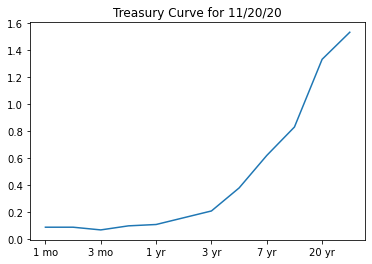

In [5]:
# plot the rfr
rfr_date = rfr_df.iloc[-1][0]

cur_rfr = rfr_df.iloc[-1][1:].astype(float)
cur_rfr.plot(title="Treasury Curve for {}".format(rfr_date))

In [6]:
# BSM model

# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma, option_type='call'):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type=='call':
        return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)
    elif option_type=='put':
        return K*np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
        
# get the (num days to expiration) / (trading days in a year)
def get_time_to_expiration(expiration_datetime_utc):
    return (expiration_datetime_utc - datetime.now(timezone.utc)).days / 252


In [7]:
value_s = black_scholes(S = 69, 
                        K = 70, 
                        T = 6/12, 
                        r = .05, 
                        sigma = .35,
                        option_type='put')
print(value_s)

6.401407649076464


In [8]:
# the rfr should vary with time, not be constant.

cur_stock_price = df.iloc[-1]['Adj Close']
time_to_expiration = get_time_to_expiration(expiration_datetime)
risk_free_rate = 0.09

# Calculate the volatility as the annualized standard deviation of the stock returns
sigma = np.sqrt(252) * df['returns'].std()

print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
list_estimates = []

strike_start_idx, strike_end_idx = 0, r.shape[0]
# strike_start_idx, strike_end_idx = 0, 21

# run BSM for different strikes
for x in range(strike_start_idx,strike_end_idx):
    value_s = black_scholes(S = cur_stock_price, 
                            K = r['Strike'][x], 
                            T = time_to_expiration, 
                            r = risk_free_rate, 
                            sigma = sigma)
    list_estimates.append(value_s)
    
# merge the real and computed dataframes to compare results
df_list = pd.DataFrame(data=list_estimates, index=r.index[strike_start_idx:strike_end_idx])
df_list['estimate'] = df_list[0]
del df_list[0]
df_estimate = r.merge(df_list, right_index = True, left_index = True)

cur_stock_price: 489.60998499999994, time to expiration: 0.04365079365079365, rfr: 0.09, vol: 0.8815712722903746


In [9]:
df_estimate

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate
0,TSLA201204C00020000,2020-11-19 3:34PM EST,20.0,478.55,466.85,471.75,0.00,-,5,7,968.56%,469.688402
1,TSLA201204C00100000,2020-11-20 2:56PM EST,100.0,393.70,386.85,391.75,393.70,-,5,10,451.76%,390.002071
2,TSLA201204C00250000,2020-11-20 3:41PM EST,250.0,242.27,237.10,241.85,-9.48,-3.77%,18,4,205.23%,240.592077
3,TSLA201204C00260000,2020-11-20 3:08PM EST,260.0,233.73,227.00,231.85,35.72,+18.04%,5,6,194.68%,230.633927
4,TSLA201204C00270000,2020-11-17 9:36AM EST,270.0,183.35,217.20,221.90,0.00,-,3,9,185.33%,220.678747
...,...,...,...,...,...,...,...,...,...,...,...,...
95,TSLA201204C00850000,2020-11-20 3:38PM EST,850.0,0.39,0.20,0.59,0.39,-,12,-,121.58%,0.049544
96,TSLA201204C00875000,2020-11-20 3:25PM EST,875.0,0.34,0.15,0.48,0.34,-,3,-,123.63%,0.028620
97,TSLA201204C00900000,2020-11-20 3:39PM EST,900.0,0.28,0.20,0.42,0.28,-,11,-,128.52%,0.016441
98,TSLA201204C00925000,2020-11-20 3:53PM EST,925.0,0.12,0.12,0.15,0.12,-,152,-,122.27%,0.009400


<AxesSubplot:title={'center':'Computed v Market prices for TSLA, Expiry 2020-12-04'}, xlabel='Strike'>

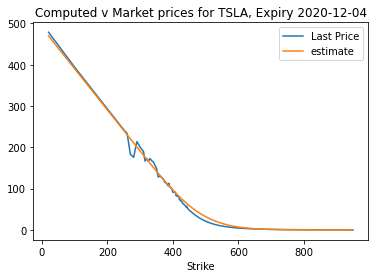

In [10]:
# plot option prices across strikes

df_estimate.plot(x='Strike',y=['Last Price','estimate'], title='Computed v Market prices for {}, Expiry {}'.format(ticker, expiration_datetime.date()))

count     100.000000
mean       57.987969
std       285.249215
min       -40.895065
25%       -30.012323
50%        -7.212643
75%         1.183640
max      1603.008607
Name: estimate_error, dtype: float64


/home/amao/miniconda3/envs/datasci/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


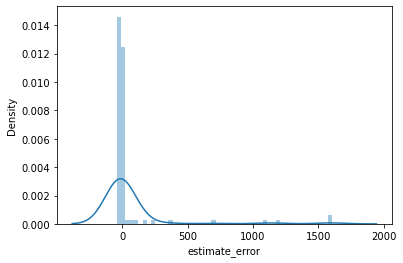

In [11]:
df_estimate['estimate_error'] = ((df_estimate['Last Price'] - df_estimate['estimate'])/df_estimate['estimate'])*100
ax = sns.distplot(df_estimate['estimate_error'])
print(df_estimate['estimate_error'].describe())

# across strikes, the median error is 34%, but there is a huge spread and outliers, 
# which mainly seem to be due to the higher strikes being very close to 0.

In [12]:
# examine outliers

df_estimate[df_estimate['estimate_error'].abs() > 1]

# the model tends to undervalue puts especially at high strikes (deep out of the money).

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate,estimate_error
0,TSLA201204C00020000,2020-11-19 3:34PM EST,20.0,478.55,466.85,471.75,0.00,-,5,7,968.56%,469.688402,1.886697
3,TSLA201204C00260000,2020-11-20 3:08PM EST,260.0,233.73,227.00,231.85,35.72,+18.04%,5,6,194.68%,230.633927,1.342419
4,TSLA201204C00270000,2020-11-17 9:36AM EST,270.0,183.35,217.20,221.90,0.00,-,3,9,185.33%,220.678747,-16.915425
5,TSLA201204C00280000,2020-11-17 9:32AM EST,280.0,175.65,207.10,211.95,0.00,-,1,16,176.25%,210.729111,-16.646542
6,TSLA201204C00290000,2020-11-19 10:10AM EST,290.0,213.83,197.25,201.90,0.00,-,1,6,165.97%,200.789212,6.494765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,TSLA201204C00850000,2020-11-20 3:38PM EST,850.0,0.39,0.20,0.59,0.39,-,12,-,121.58%,0.049544,687.180752
96,TSLA201204C00875000,2020-11-20 3:25PM EST,875.0,0.34,0.15,0.48,0.34,-,3,-,123.63%,0.028620,1087.966543
97,TSLA201204C00900000,2020-11-20 3:39PM EST,900.0,0.28,0.20,0.42,0.28,-,11,-,128.52%,0.016441,1603.008607
98,TSLA201204C00925000,2020-11-20 3:53PM EST,925.0,0.12,0.12,0.15,0.12,-,152,-,122.27%,0.009400,1176.658542


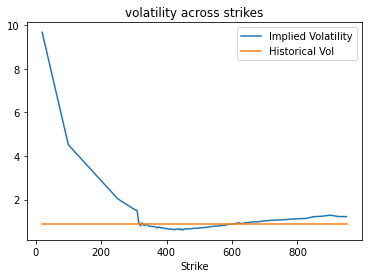

In [13]:
# how accurate are our vol estimates?

df_estimate['Implied Volatility'] = df_estimate['Implied Volatility'].str.replace(',','').str.slice(stop=-1).astype('float') / 100

df_estimate['Historical Vol'] = sigma
ax = df_estimate.plot(x='Strike',y=['Implied Volatility','Historical Vol'],title='volatility across strikes')

<AxesSubplot:title={'center':'volume and open interest'}, xlabel='Strike'>

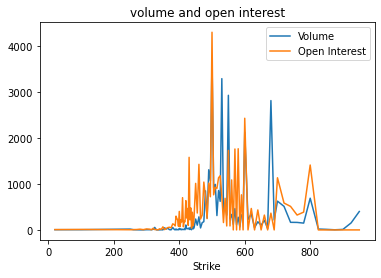

In [14]:
df_estimate['Volume'] = df_estimate['Volume'].replace(to_replace='-',value=0)
df_estimate['Volume'] = df_estimate['Volume'].astype('int')

df_estimate['Open Interest'] = df_estimate['Open Interest'].replace(to_replace='-',value=0)
df_estimate['Open Interest'] = df_estimate['Open Interest'].astype('int')

df_estimate.plot(x='Strike',y=['Volume','Open Interest'],title='volume and open interest')

<AxesSubplot:title={'center':'estimate error across strikes'}, xlabel='Strike'>

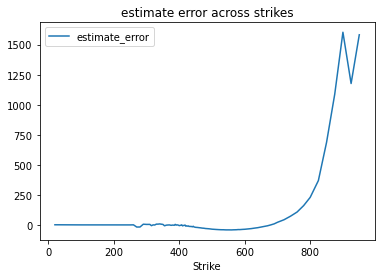

In [15]:
# plot the error across strikes

df_estimate.plot(x='Strike',y='estimate_error',title='estimate error across strikes')


In [16]:
# what is a measure of error?
# MSE: average of the sum of squared errors

mse = np.sum((df_estimate['Last Price'] - df_estimate['estimate'])**2) / df_estimate.shape[0]
rmse = np.sqrt(mse)

print(mse, rmse)
# could also try MAD

71.596433361587 8.461467565475093


count    88.000000
mean    -14.575457
std      18.037489
min     -40.895065
25%     -32.763989
50%     -11.417336
75%      -0.236306
max      43.614032
Name: estimate_error, dtype: float64


/home/amao/miniconda3/envs/datasci/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Option prices for TSLA, Expiry 2020-12-04 (Filtered Strikes)'}, xlabel='Strike'>

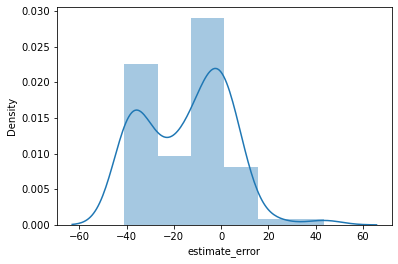

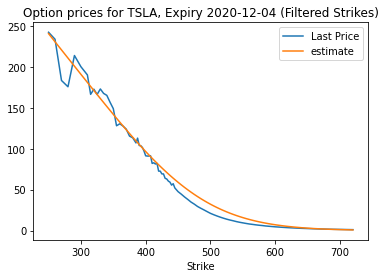

In [17]:
# filter deep ITM and OTM options

lower_bound, upper_bound = cur_stock_price * .5, cur_stock_price * 1.5
put_estimate_filtered = df_estimate[(df_estimate['Strike'] > lower_bound) & (df_estimate['Strike'] < upper_bound)].reset_index()
ax = sns.distplot(put_estimate_filtered['estimate_error'])
print(put_estimate_filtered['estimate_error'].describe())

put_estimate_filtered.plot(x='Strike',y=['Last Price','estimate'], title='Option prices for {}, Expiry {} (Filtered Strikes)'.format(ticker, expiration_datetime.date()))


In [18]:
put_estimate_filtered

,index,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate,estimate_error,Historical Vol
0,2,TSLA201204C00250000,2020-11-20 3:41PM EST,250.0,242.27,237.10,241.85,-9.48,-3.77%,18,4,2.0523,240.592077,0.697414,0.881571
1,3,TSLA201204C00260000,2020-11-20 3:08PM EST,260.0,233.73,227.00,231.85,35.72,+18.04%,5,6,1.9468,230.633927,1.342419,0.881571
2,4,TSLA201204C00270000,2020-11-17 9:36AM EST,270.0,183.35,217.20,221.90,0.00,-,3,9,1.8533,220.678747,-16.915425,0.881571
3,5,TSLA201204C00280000,2020-11-17 9:32AM EST,280.0,175.65,207.10,211.95,0.00,-,1,16,1.7625,210.729111,-16.646542,0.881571
4,6,TSLA201204C00290000,2020-11-19 10:10AM EST,290.0,213.83,197.25,201.90,0.00,-,1,6,1.6597,200.789212,6.494765,0.881571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,85,TSLA201204C00670000,2020-11-20 3:59PM EST,670.0,1.88,1.72,2.13,1.88,-,29,0,0.9775,2.006664,-6.312166,0.881571
84,86,TSLA201204C00680000,2020-11-20 3:59PM EST,680.0,1.68,1.51,1.71,-1.04,-38.24%,2810,364,0.9797,1.659336,1.245288,0.881571
85,87,TSLA201204C00690000,2020-11-20 3:34PM EST,690.0,1.50,1.33,1.74,1.50,-,214,0,1.0051,1.368984,9.570331,0.881571
86,88,TSLA201204C00700000,2020-11-20 3:58PM EST,700.0,1.38,1.26,1.54,-0.77,-35.81%,625,1133,1.0217,1.126960,22.453372,0.881571


cur_stock_price: 489.60998499999994, time to expiration: 0.04365079365079365, rfr: 0.09, vol: 0.8815712722903746


<AxesSubplot:title={'center':'Option Prices for TSLA, Expiry 2020-12-04, with Implied Vol'}, xlabel='Strike'>

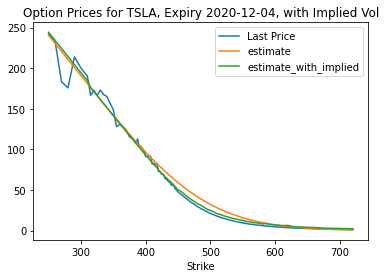

In [19]:
# if we use implied vol instead of historical vol, our estimate should improve

def calculate_prices_across_strikes(options_df, cur_stock_price, time_to_expiration, risk_free_rate, sigma):

    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
    list_estimates = []

    strike_start_idx, strike_end_idx = 0, options_df.shape[0]

    # run BSM for different strikes
    for x in range(strike_start_idx,strike_end_idx):
#         print(options_df['Strike'][x])
        value_s = black_scholes(S = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = options_df['Implied Volatility'][x])
        list_estimates.append(value_s)

    # merge the real and computed dataframes to compare results
    options_df['estimate_with_implied'] = list_estimates

    return options_df

df_estimate = calculate_prices_across_strikes(put_estimate_filtered, cur_stock_price, time_to_expiration, risk_free_rate, sigma)
df_estimate.plot(x='Strike',y=['Last Price','estimate','estimate_with_implied'], title='Option Prices for {}, Expiry {}, with Implied Vol'.format(ticker, expiration_datetime.date()))

count    88.000000
mean    -11.715594
std      15.723901
min     -49.267853
25%     -22.878953
50%      -6.016633
75%       0.809531
max       8.954699
Name: estimate_with_implied_error, dtype: float64


/home/amao/miniconda3/envs/datasci/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Estimate Percent Error Across Strikes (Filtered Strikes)'}, xlabel='Strike'>

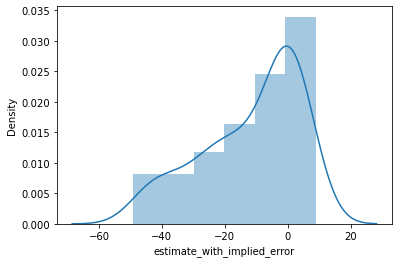

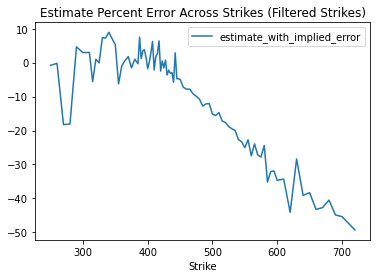

In [20]:

df_estimate['estimate_with_implied_error'] = ((df_estimate['Last Price'] - df_estimate['estimate_with_implied'])/df_estimate['estimate_with_implied'])*100
ax = sns.distplot(df_estimate['estimate_with_implied_error'])
print(df_estimate['estimate_with_implied_error'].describe())
put_estimate_filtered.plot(x='Strike',y='estimate_with_implied_error',title='Estimate Percent Error Across Strikes (Filtered Strikes)')


In [21]:
mse = np.sum((df_estimate['Last Price'] - df_estimate['estimate_with_implied'])**2) / df_estimate.shape[0]
rmse = np.sqrt(mse)

print(mse, rmse)

53.05644604654185 7.283985588024035


In [22]:
# how accurate is BSM for different expiration dates?

import os 

data_path = "/home/amao/options_data/2020-11-19 17:00:01.568118"

ticker = 'TSLA'
calls_data, puts_data = dict(), dict()

for filename in os.listdir(data_path):
    if ticker in filename:
        df = pd.read_csv(os.path.join(data_path, filename))
        if 'puts' in filename :
            puts_data[filename] = df
        elif 'calls' in filename:
            calls_data[filename] = df
        
print(len(calls_data), len(puts_data))

4 4


In [23]:
# stock_price_df = df

# for k,v in calls_data.items():
#     print(k, v.head())
#     bsm_estimate_df = calculate_prices_across_strikes(v, cur_stock_price, time_to_expiration, risk_free_rate, sigma):


In [24]:
# binomial tree
import math

sigma = .2
rfr = .02
delta_t = 1

u = math.exp(sigma * math.sqrt(delta_t))
d = math.exp(-sigma * math.sqrt(delta_t))
print('u and d:',u,d)

# a = math.exp(rfr * delta_t)
a = math.exp((rfr - .01) * delta_t)
p = (a - d)/(u - d)

print('p', p)


u and d: 1.2214027581601699 0.8187307530779818
p 0.47512469600943963


In [25]:
# N period binomial tree model

def price_option_european(S_0, u, d, K, option_type: str, num_periods: int):
    
    if num_periods == 0:
        if option_type == 'call':
            return max(S_0-K, 0)
        elif option_type == 'put':
            return max(K-S_0, 0)
    else:
        S_u = S_0 * u
        S_d = S_0 * d
        
        f_u = price_option_european(S_0 * u,u,d,K,option_type,num_periods-1)
        f_d = price_option_european(S_0 * d,u,d,K,option_type,num_periods-1)
        
#         print('f_u and f_d:', f_u, f_d)

        return math.exp(-rfr*delta_t) * (p*f_u + (1-p)*f_d)

S_0 = 200
K = 200
option_type = 'put'

for i in range(5):
    price = price_option_european(S_0, u, d, K, option_type, num_periods=i)
    print('price',price)
    

price 0
price 18.65195571686643
price 17.452716560268637
price 25.695678025946652
price 24.44307753439426


In [27]:
def price_option_american(S_0, u, d, K, option_type: str, num_periods: int):
    
    if num_periods == 0:
        if option_type == 'call':
            return max(S_0-K, 0)
        elif option_type == 'put':
            return max(K-S_0, 0)
    else:
        S_u = S_0 * u
        S_d = S_0 * d
        
        f_u = price_option_american(S_0 * u,u,d,K,option_type,num_periods-1)
        f_d = price_option_american(S_0 * d,u,d,K,option_type,num_periods-1)
        
        if option_type == 'call':
            f_u_early = max(S_u-K, 0)
            f_d_early = max(S_d-K, 0)
        elif option_type == 'put':
            f_u_early = max(K-S_u, 0)
            f_d_early = max(K-S_d, 0)
#         print('f_u,f_d,f_u_early,f_d_early:',f_u,f_d,f_u_early,f_d_early)
        f_u = max(f_u,f_u_early)
        f_d = max(f_u,f_d_early)
        
#         print('f_u and f_d:', f_u, f_d)

        return math.exp(-rfr*delta_t) * (p*f_u + (1-p)*f_d)

S_0 = 200
K = 200
option_type = 'put'

for i in range(5):
    price = price_option_american(S_0, u, d, K, option_type, num_periods=i)
    print('price',price)

price 0
price 18.65195571686643
price 18.65195571686643
price 18.65195571686643
price 18.65195571686643
